In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset.dataloader import SHREC22_data
from contrastive.moco import MoCo
from augmentations.augmentations import augmentations_sequence
from encoders.encoders import STGCN_model
from classification.classification import SSL_model

### Self-supervised learning

In [2]:
# Hyperparameters
train_path = './dataset/training_set/training_set/'
test_path = './dataset/training_set/test_set/'
batch_size = 64
n_epochs = 2000
learning_rate = 0.001
queue_size = 30000
T = 90  # Sequence length
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load train data
trainset = SHREC22_data(train_path, T)
train_ssl_size = int(0.9 * len(trainset)) # 90% unlabeled data for self-supervised
train_classify_size = len(trainset) - train_ssl_size
train_ssl_set, train_classify_set = torch.utils.data.random_split(trainset, [train_ssl_size, train_classify_size], generator=torch.Generator().manual_seed(42))
trainloader_ssl = DataLoader(train_ssl_set, batch_size=batch_size, shuffle=True)

In [27]:
graph_args = {
    'strategy': 'spatial',
    'max_hop': 1,
    'dilation': 1
}

# Data augmentation
augmentations = augmentations_sequence()

# Load base encoder for MoCo
base_encoder = STGCN_model(in_channels=3, hidden_channels=64, hidden_dim=256, out_dim=512, graph_args=graph_args, edge_importance_weighting=True)

# Load MoCo Model
moco_model = MoCo(base_encoder=base_encoder, dim = 512, K=queue_size, m=0.999, T = 0.07).to(device)

In [5]:
optimizer = optim.Adam(moco_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Training
moco_model.train()
train_loss = []
for epoch in tqdm(range(n_epochs)):
  total_loss = 0.0
  for batch in trainloader_ssl:
    seqs = batch['Sequence'].float().to(device)
    seqs_aug1 = augmentations(seqs)
    seqs_aug2 = augmentations(seqs)

    optimizer.zero_grad()
    # Forward pass
    logits, labels = moco_model(seqs_aug1, seqs_aug2)
    loss = loss_fn(logits, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  train_loss.append(total_loss/len(trainloader_ssl))
  if (epoch+1) % 200 == 0:
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(trainloader_ssl):.4f}")

 10%|█         | 200/2000 [06:48<1:01:57,  2.07s/it]

Epoch [200/2000], Loss: 6.3057


 20%|██        | 400/2000 [13:42<55:53,  2.10s/it]  

Epoch [400/2000], Loss: 5.3112


 30%|███       | 600/2000 [20:31<47:33,  2.04s/it]

Epoch [600/2000], Loss: 4.1634


 40%|████      | 800/2000 [27:17<40:46,  2.04s/it]

Epoch [800/2000], Loss: 3.7675


 50%|█████     | 1000/2000 [34:04<33:48,  2.03s/it]

Epoch [1000/2000], Loss: 2.9148


 60%|██████    | 1200/2000 [40:51<27:08,  2.04s/it]

Epoch [1200/2000], Loss: 2.5031


 70%|███████   | 1400/2000 [47:38<20:28,  2.05s/it]

Epoch [1400/2000], Loss: 2.0532


 80%|████████  | 1600/2000 [54:25<13:31,  2.03s/it]

Epoch [1600/2000], Loss: 1.6978


 90%|█████████ | 1800/2000 [1:01:12<06:46,  2.03s/it]

Epoch [1800/2000], Loss: 1.3908


100%|██████████| 2000/2000 [1:07:59<00:00,  2.04s/it]

Epoch [2000/2000], Loss: 1.3992


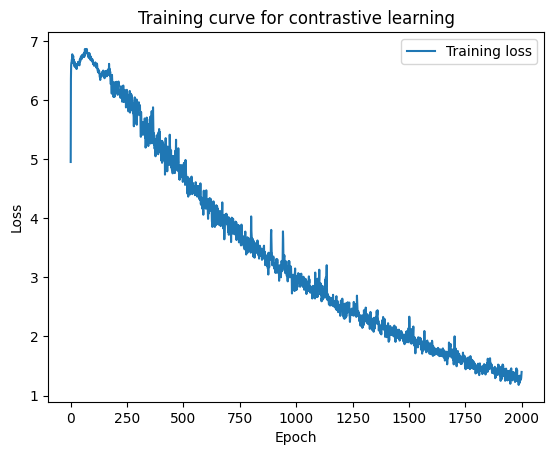

In [6]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.title('Training curve for contrastive learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Save the query encoder for downstream task
torch.save(moco_model.encoder_q.state_dict(), 'encoder_q_90.pth')

### Downstream Classification

In [4]:
# load the query encoder
graph_args = {
    'strategy': 'spatial',
    'max_hop': 1,
    'dilation': 1
}
q_encoder = STGCN_model(in_channels=3, hidden_channels=64, hidden_dim=256, out_dim=512, graph_args=graph_args, edge_importance_weighting=True)
q_encoder.load_state_dict(torch.load("encoder_q_90.pth"))

C:\Users\Asus\AppData\Local\Temp\ipykernel_9188\1057116271.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_encoder.load_state_dict(torch.load("encoder_q_90.pth"))


<All keys matched successfully>

In [5]:
# classifier
trainloader_classify = DataLoader(train_classify_set, batch_size=8, shuffle=True)
classifier_model = SSL_model(contrastive_encoder=q_encoder, classifier_dim=512, num_classes=16).to(device)
for param in classifier_model.contrastive_encoder.parameters():
    param.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.classifier.parameters(), lr=learning_rate)

In [6]:
# Training Loop
train_loss, train_acc = [], []
n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in trainloader_classify:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)
        
        optimizer.zero_grad()
        # Forward pass
        output = classifier_model(seqs)
        loss = loss_fn(output, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(total_loss / len(trainloader_classify))
    train_acc.append(correct / total)
  
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.4f}")


 26%|██▌       | 13/50 [00:00<00:02, 16.47it/s]

Epoch [10/50], Loss: 1.2809, Accuracy: 0.7759


 46%|████▌     | 23/50 [00:01<00:01, 17.53it/s]

Epoch [20/50], Loss: 0.8016, Accuracy: 0.8793


 66%|██████▌   | 33/50 [00:02<00:00, 18.21it/s]

Epoch [30/50], Loss: 0.6026, Accuracy: 0.9310


 86%|████████▌ | 43/50 [00:02<00:00, 18.59it/s]

Epoch [40/50], Loss: 0.4234, Accuracy: 0.9483


100%|██████████| 50/50 [00:03<00:00, 16.64it/s]

Epoch [50/50], Loss: 0.3329, Accuracy: 0.9655
